# Preparing Alpha Factors and Features to predict Stock Returns

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [3]:
MONTH = 21
YEAR = 12 * MONTH

In [4]:
START = '2013-01-01'
END = '2017-12-31'

In [5]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

## Loading Quandl Wiki Stock Prices & Meta Data

In [6]:
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']

In [7]:
DATA_STORE = '../data/assets.h5'

In [12]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['finance_datareader/prices']
              .loc[idx[START:END, :], ohlcv]
              .rename(columns=lambda x: x.replace('adj_', ''))
              .assign(volume=lambda x: x.volume.div(1000))
              .swaplevel()
              .sort_index())

    stocks = (store['kospi/stocks']
              .loc[:, ['시가총액', '상장일', 'sector']])

## Remove stocks with few observations

In [13]:
# want at least 2 years of data
min_obs = 2 * YEAR

# have this much per ticker 
nobs = prices.groupby(level='ticker').size()

# keep those that exceed the limit
keep = nobs[nobs > min_obs].index

prices = prices.loc[idx[keep, :], :]

### Align price and meta data

In [14]:
stocks = stocks[~stocks.index.duplicated() & stocks.sector.notnull()]
stocks.sector = stocks.sector.str.lower().str.replace(' ', '_')
stocks.index.name = 'ticker'

In [15]:
shared = (prices.index.get_level_values('ticker').unique()
          .intersection(stocks.index))
stocks = stocks.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

In [16]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 799733 entries, ('000020', Timestamp('2013-01-02 00:00:00')) to ('900140', Timestamp('2017-12-28 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    799733 non-null  float64
 1   close   799733 non-null  float64
 2   low     799733 non-null  float64
 3   high    799733 non-null  float64
 4   volume  799733 non-null  float64
dtypes: float64(5)
memory usage: 33.9+ MB


In [17]:
stocks.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 669 entries, 000020 to 900140
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시가총액    669 non-null    int64  
 1   상장일     669 non-null    float64
 2   sector  669 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 20.9+ KB


In [18]:
stocks.sector.value_counts()

기타_금융업             51
자동차_신품_부품_제조업      39
의약품_제조업            35
1차_철강_제조업          31
기타_화학제품_제조업        26
                   ..
그외_기타_제품_제조업        1
산업용_기계_및_장비_임대업     1
금속_주조업              1
기타_비금속광물_광업         1
비알코올음료_및_얼음_제조업     1
Name: sector, Length: 120, dtype: int64

Optional: persist intermediate results:

In [19]:
# with pd.HDFStore('tmp.h5') as store:
#     store.put('prices', prices)
#     store.put('stocks', stocks)

In [20]:
# with pd.HDFStore('tmp.h5') as store:
#     prices = store['prices']
#     stocks = store['stocks']

## Compute Rolling Average Dollar Volume

In [21]:
# compute dollar volume to determine universe
prices['dollar_vol'] = prices[['close', 'volume']].prod(axis=1)

In [22]:
prices['dollar_vol_1m'] = (prices.dollar_vol.groupby('ticker')
                           .rolling(window=21, level='date')
                           .mean()).values

In [23]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 799733 entries, ('000020', Timestamp('2013-01-02 00:00:00')) to ('900140', Timestamp('2017-12-28 00:00:00'))
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   open           799733 non-null  float64
 1   close          799733 non-null  float64
 2   low            799733 non-null  float64
 3   high           799733 non-null  float64
 4   volume         799733 non-null  float64
 5   dollar_vol     799733 non-null  float64
 6   dollar_vol_1m  786353 non-null  float64
dtypes: float64(7)
memory usage: 46.1+ MB


In [24]:
prices['dollar_vol_rank'] = (prices.groupby('date')
                             .dollar_vol_1m
                             .rank(ascending=False))

In [25]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 799733 entries, ('000020', Timestamp('2013-01-02 00:00:00')) to ('900140', Timestamp('2017-12-28 00:00:00'))
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             799733 non-null  float64
 1   close            799733 non-null  float64
 2   low              799733 non-null  float64
 3   high             799733 non-null  float64
 4   volume           799733 non-null  float64
 5   dollar_vol       799733 non-null  float64
 6   dollar_vol_1m    786353 non-null  float64
 7   dollar_vol_rank  786353 non-null  float64
dtypes: float64(8)
memory usage: 52.2+ MB


## Add some Basic Factors

### Compute the Relative Strength Index

In [26]:
prices['rsi'] = prices.groupby(level='ticker').close.apply(RSI)

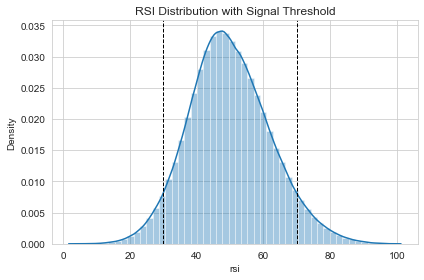

In [27]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout();

### Compute Bollinger Bands

In [28]:
def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

In [29]:
prices = (prices.join(prices
                      .groupby(level='ticker')
                      .close
                      .apply(compute_bb)))

In [30]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

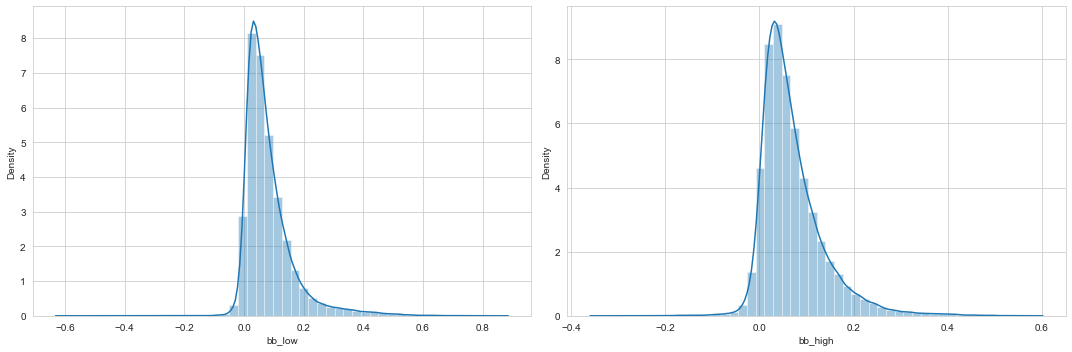

In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
plt.tight_layout();

### Compute Average True Range

In [32]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [33]:
prices['atr'] = (prices.groupby('ticker', group_keys=False)
                 .apply(compute_atr))

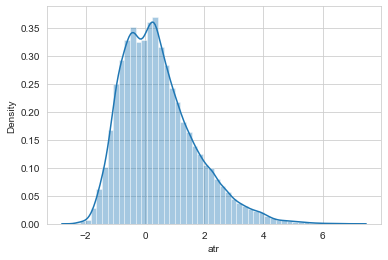

In [34]:
sns.distplot(prices[prices.dollar_vol_rank<50].atr.dropna());

### Compute Moving Average Convergence/Divergence

In [35]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [36]:
prices['macd'] = (prices
                  .groupby('ticker', group_keys=False)
                  .close
                  .apply(compute_macd))

In [37]:
prices.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    777,656.0
mean           0.0
std            1.0
min          -10.0
0.1%          -3.7
1%            -2.4
2%            -2.0
3%            -1.8
4%            -1.6
5%            -1.5
50%           -0.1
95%            1.7
96%            1.9
97%            2.1
98%            2.5
99%            3.1
99.9%          5.2
max            9.9
Name: macd, dtype: object

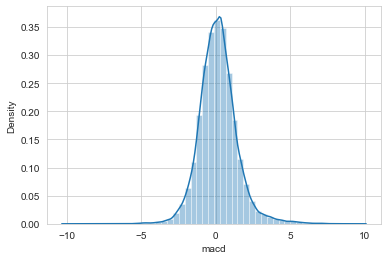

In [38]:
sns.distplot(prices[prices.dollar_vol_rank<100].macd.dropna());

## Compute Lagged Returns

In [39]:
lags = [1, 5, 10, 21, 42, 63]

In [40]:
returns = prices.groupby(level='ticker').close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,2.65%
min,-30.00%
0.01%,-24.78%
0.1%,-14.61%
1%,-6.37%
50%,0.00%
99%,8.16%
99.9%,17.95%
99.99%,29.98%
max,30.26%


In [41]:
q = 0.0001

### Winsorize outliers

In [42]:
for lag in lags:
    prices[f'return_{lag}d'] = (prices.groupby(level='ticker').close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

### Shift lagged returns

In [43]:
for t in [1, 2, 3, 4, 5]:
    for lag in [1, 5, 10, 21]:
        prices[f'return_{lag}d_lag{t}'] = (prices.groupby(level='ticker')
                                           [f'return_{lag}d'].shift(t * lag))

## Compute Forward Returns

In [44]:
for t in [1, 5, 10, 21]:
    prices[f'target_{t}d'] = prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)

## Combine Price and Meta Data

In [45]:
prices = prices.join(stocks[['sector']])

## Create time and sector dummy variables

In [46]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month

In [47]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 799733 entries, ('000020', Timestamp('2013-01-02 00:00:00')) to ('900140', Timestamp('2017-12-28 00:00:00'))
Data columns (total 46 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   open             799733 non-null  float64
 1   close            799733 non-null  float64
 2   low              799733 non-null  float64
 3   high             799733 non-null  float64
 4   volume           799733 non-null  float64
 5   dollar_vol       799733 non-null  float64
 6   dollar_vol_1m    786353 non-null  float64
 7   dollar_vol_rank  786353 non-null  float64
 8   rsi              790367 non-null  float64
 9   bb_high          787022 non-null  float64
 10  bb_low           787022 non-null  float64
 11  atr              790367 non-null  float64
 12  macd             777656 non-null  float64
 13  return_1d        799064 non-null  float64
 14  return_5d        796388 non-null  float64
 15  retu

In [48]:
prices.assign(sector=pd.factorize(prices.sector, sort=True)[0]).to_hdf('data.h5', 'model_data/no_dummies')

In [49]:
prices = pd.get_dummies(prices,
                        columns=['year', 'month', 'sector'],
                        prefix=['year', 'month', ''],
                        prefix_sep=['_', '_', ''],
                        drop_first=True)

In [50]:
prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 799733 entries, ('000020', Timestamp('2013-01-02 00:00:00')) to ('900140', Timestamp('2017-12-28 00:00:00'))
Columns: 177 entries, open to 회사_본부_및_경영_컨설팅_서비스업
dtypes: float64(43), uint8(134)
memory usage: 384.1+ MB


## Store Model Data

In [51]:
prices.to_hdf('data.h5', 'model_data')

## Explore Data

### Plot Factors

In [52]:
target = 'target_5d'
top100 = prices[prices.dollar_vol_rank<100].copy()

### RSI

In [53]:
top100.loc[:, 'rsi_signal'] = pd.cut(top100.rsi, bins=[0, 30, 70, 100])

In [54]:
top100.groupby('rsi_signal')['target_5d'].describe()

,count,mean,std,min,25%,50%,75%,max
rsi_signal,,,,,,,,
"(0, 30]",4669.0,0.000964,0.013707,-0.111266,-0.005500,0.000937,0.007164,0.139152
"(30, 70]",107780.0,-0.000438,0.011912,-0.111266,-0.006278,-0.000463,0.005454,0.143862
"(70, 100]",6737.0,-0.001553,0.018461,-0.111266,-0.008279,-0.001574,0.005301,0.143862


### Bollinger Bands

-7.05% (0.00%)


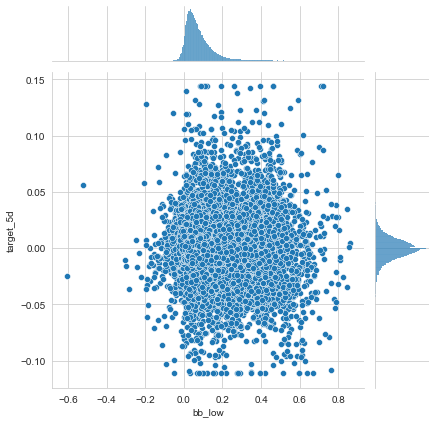

In [55]:
metric = 'bb_low'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

0.02% (93.53%)


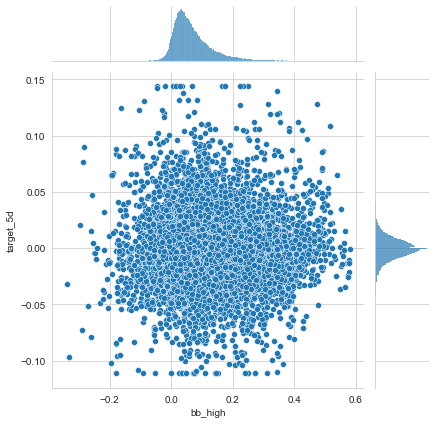

In [56]:
metric = 'bb_high'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### ATR

-9.01% (0.00%)


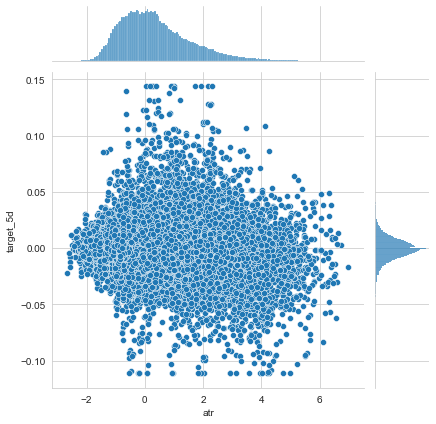

In [57]:
metric = 'atr'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')

### MACD

-5.08% (0.00%)


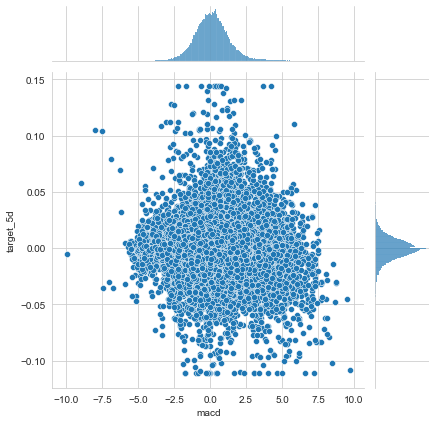

In [58]:
metric = 'macd'
j=sns.jointplot(x=metric, y=target, data=top100)

df = top100[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])
print(f'{r:,.2%} ({p:.2%})')